# Example:  Joint Eikonal and DC Resistivity Inversion

This example demonstrates how to use `jInv` for multiphysics inversions. Here, we jointly invert 3D travel time and DC resitivity data. Our example geophysical imaging technique. 

Our goal is to solve the inverse problem

\begin{equation*}
		\min_{m} \sum_{j=1}^{n^{\rm Eik}} \| P^{\rm Eik}_j u^{\rm Eik}_j(m) - d^{\rm Eik}_{j}\|^2 + \sum_{j=1}^{n^{\rm DC}} \| P^{\rm DC}_j u^{\rm DC}_j(m) - d^{\rm DC}_{j}\|^2 + \alpha \| L m\|^2 
        \quad \text{ subject to} \quad m_L \leq m \leq x_H
\end{equation*}

where 

* $m$ - is the model
* $u_j^{\rm Eik}$ - is the travel time for the $j$th source
* $d_{j}^{\rm Eik}$ - is the measured data for the $j$th source
* $P_j^{\rm Eik}$ - are the receiver matrices for the travel time
* $u_j^{\rm DC}$ - is the electric potential for the $j$th source
* $d_{j}^{\rm DC}$ - is the measured resistivity data for the $j$th source
* $P_j^{\rm DC}$ - are the receiver matrices for the DC resistivity data
* $\alpha>0$ and $L$ is the regularization parameter and operator, respectively
* $m_L,m_H$ are lower and uppter bounds on the model

## References
This experiment combines the data inverted in the notebooks [`exDCResistivity.ipynb`](https://github.com/JuliaInv/jInv.jl/blob/master/examples/exDCResistivity.ipynb) and [`exEikonal.ipynb`](https://github.com/JuliaInv/jInv.jl/blob/master/examples/exEikonal.ipynb) and is also described in [1]. You may compare the results of this joint inversion to the results in the other two examples. The fast marching method used to solve the Eikonal equation is presented in [2]. The test data here is generated using jInv and based on the 3D SEG/EAGE model of a salt reservoir described in [3]. Thus, please see and reference the following papers when using this example:

[1]  Ruthotto L, Treister E, Haber E: [jInv - a flexible Julia package for PDE parameter estimation](http://arxiv.org/abs/1606.07399), arXiv:1606.0739 [cs.MS] 2016

[2] Treister E, Haber E: [A fast marching algorithm for the factored eikonal equation](http://dx.doi.org/10.1016/j.jcp.2016.08.012), Journal of Computational Physics, 324(1), p. 210–225, 2016

[3] F. Aminzadeh, B. Jean, and T. Kunz. 3-D salt and overthrust models. Society of Exploration Geophysicists, 1997.


## Add parallel workers

The forward problems in our Eikonal package are solved using a fast marching method. This by itself is difficult to parallelize, however, as common in practice we have multiple measurements that need to be simulated. Our package automatically uses this potential for parallelization and uses all available workers. 

So, before you start this experiment we recommend you add workers. Here, we just use local workers, but you may also use MPI or SSH to connect to remote workers. The parallelism in `jInv` is designed to be communication efficient. 

In [1]:
addprocs(8)

8-element Array{Int64,1}:
 2
 3
 4
 5
 6
 7
 8
 9

In [14]:
using MAT
using PyPlot
using EikonalInv
using DivSigGrad
using jInv.InverseSolve
using jInv.Mesh
using jInv.ForwardShare
using jInv.Utils
using jInvVis
using jInv.LinearSolvers

## Load Data

Data can be found in the files `exEikonal.mat` and `exDCResistivity.mat`.


In [3]:
matfile      = matread("exEikonal.mat")
ReceiversEik = matfile["Receivers"] # sparse matrix with discrete Eikonal receivers
SourcesEik   = matfile["Sources"] # sparse matrix with discrete Eikonal sources
dobsEik      = matfile["dobs"]    # observations simulated with true model
dobs0Eik     = matfile["dobs0"]   # observations simulated for reference model
slowref      = matfile["slowref"] # reference slowness, serves as starting guess

n            = matfile["n"]       # size of mesh used for the model
domain       = matfile["domain"]  # domain size
mref         = matfile["mref"];   # reference model
WdEik        = matfile["Wd"];     # weighting matrix for misfit;

matfile   = matread("exDCResistivity.mat")
ReceiversDC = matfile["Receivers"] # sparse matrix with discrete DC Receivers
SourcesDC   = matfile["Sources"]  # sparse matrix with discrete DC sources
dobsDC      = matfile["dobs"]     # observations simulated with true model
dobs0DC     = matfile["dobs0"]    # observations simulated for reference model
nfwd      = matfile["nfwd"]       # size of mesh used to solve PDEs
sigref    = matfile["sigref"];    # reference guess for conductivity;

## Setup Meshes

In this block we set up three different meshes used in the inversion.

In our Eikonal forward solver, the travel time and slowness are discretized on a nodal grid. This is in contrast to other jInv modules. To make this seamless, we use a shifted grid.

To accelerate the DC Resistivity simulations we use mesh decoupling and solve the forward problem on a coarser mesh.

In [4]:
h           = (domain[2:2:end]-domain[1:2:end])./n
domainNodal = copy(domain); domainNodal[1:2:end] += h./2; domainNodal[2:2:end] -= h./2
Meik        = getRegularMesh(domainNodal,n-1) 

Minv        = getRegularMesh(domain,n);
Mdc         = getRegularMesh(domain,nfwd);
Mesh2Mesh   = getInterpolationMatrix(Minv,Mdc)';


## Selecting the Active Set

Sometimes we want to include some voxels from the inversion (for example, close to the boundary / sources / receivers). This can be done by the matrix `Iact` by deleting some columns from a sparse identity matrix. If we do that, the size of the model gets smaller and so we need to update the reference model as well.

In [5]:
Iact     = sparse(I,prod(n),prod(n))
mref     = Iact'*mref[:]
mback    = mref - Iact*(Iact'*mref);
slowback = slowref - Iact*(Iact'*slowref);
sigback  = vec(sigref - Iact*(Iact'*sigref));


## Setup Misfit Param

Next, we set up the misfit param for our joint inversion. We should remember three things:

1. The Eikonal forward problems will be spawned out to the first $n_w -1 $ workers. We will therefore also split up that data. Our job is to make sure that the right data ends up in the right misfit param. We do that by using the values in `SourcesSubInd`
1. The DC Resistivity problem and data will be assigned to the last worker
1. Since the functions from model to velocity and model to conductivity are different, we have to provide model functions to the misfit params

### Setup MisfitParams for Eikonal Problems

In [6]:
pForEik,contDiv,SourcesSubInd = getEikonalInvParam(Meik,SourcesEik,ReceiversEik,false,nworkers()-1)
# split up observed data and misfit weightings
WD   = Array(Array{Float64},length(pForEik));
DOBS = Array(Array{Float64},length(pForEik));
for k=1:length(pForEik)
	Ik      = SourcesSubInd[k];
    WD[k]   = WdEik[:,Ik];
    DOBS[k] = dobsEik[:,Ik];
end
modfunEik   = velocityToSlowSquared;
pMisEik     = getMisfitParam(pForEik,WD,DOBS,SSDFun,Iact,slowback,ones(length(pForEik)),modfunEik)

7-element Array{RemoteChannel,1}:
 RemoteChannel{Channel{jInv.InverseSolve.MisfitParam}}(2,1,151)
 RemoteChannel{Channel{jInv.InverseSolve.MisfitParam}}(3,1,143)
 RemoteChannel{Channel{jInv.InverseSolve.MisfitParam}}(4,1,147)
 RemoteChannel{Channel{jInv.InverseSolve.MisfitParam}}(5,1,149)
 RemoteChannel{Channel{jInv.InverseSolve.MisfitParam}}(6,1,145)
 RemoteChannel{Channel{jInv.InverseSolve.MisfitParam}}(7,1,153)
 RemoteChannel{Channel{jInv.InverseSolve.MisfitParam}}(8,1,155)

### Setup MisfitParam for DivSigGrad problem

Here, the forward problem mesh is relatively coarse. We will therefore use Julia's direct solver (MUMPS can be used as well, or iterative for larger problems). Since we have access to the factorized PDE, it will be benefitial to put all sources into a single forward problem. We'll use the last worker.

In [7]:
Ainv        = getJuliaSolver()
# Ainv        = getMUMPSsolver()
pForDC      = getDivSigGradParam(Mdc, SourcesDC, ReceiversDC, Ainv=Ainv)

gloc        = GlobalToLocal(Iact'*Mesh2Mesh,Mesh2Mesh'*sigback);
WdDC          = 1./(mean(abs(vec(dobsDC)))/2+abs(dobsDC));
@everywhere begin
    function velToConductMod(v,mid,a,b)
        d = (b-a)./2.0;
        dinv = 10;
        tt = dinv.*(mid - v);
        t = (d.*(tanh(tt)+1) + a);
        dt = -(dinv*d)*(sech(tt)).^2;
        dt = (2.0-v./mid).*dt + (-1./mid).*t;
        t = t.*(2.0-v./mid);
        return vec(t),spdiagm(vec(dt))
    end
    modfunDC(m) = velToConductMod(m,3.0,0.1,1.0);
end
pMisDC = initRemoteChannel(getMisfitParam,workers()[end],pForDC,WdDC,dobsDC,SSDFun,modfunDC,gloc)


RemoteChannel{Channel{jInv.InverseSolve.MisfitParam}}(9,1,165)

### Combining both models

Having both problems set up, running a multiphysics inversion is as simple as stacking both misfit parameters into a long vector. 

In [8]:
pMis = [pMisEik; pMisDC]  # combines both problem types;

## Configure the Inversion

In this block we set parameters for the inversion. In jInv we need to select a regularizer, its parameter, and configer the optimization problem by setting upper and lower bounds, maximum number of iterations for the outer and inner loop, a preconditioner, and a model. 

In [9]:
# configure regularization
alpha	   	= 1e-15;
regparams   = [1.0,1.0,1.0,1e-6];
regfun(m,mref,Minv) = wdiffusionReg(m,mref,Minv,Iact=Iact,C = regparams)

# configuer optimization
HesPrec     = getSSORRegularizationPreconditioner(1.0,1e-15,200);
cgit       	= 8; 
pcgTol     	= 1e-1;
maxIter    	= 10;
minUpdate 	= 1e-2;
boundsLow  	= 1.45*ones(size(Iact,2));
boundsHigh 	= 4.5 *ones(size(Iact,2));
maxStep		= 0.1*maximum(boundsHigh);

pInv = getInverseParam(Minv,identityMod,regfun,alpha,vec(mref),
         boundsLow,boundsHigh,maxStep=maxStep,pcgMaxIter=cgit,pcgTol=pcgTol,
         minUpdate=minUpdate, maxIter = maxIter,HesPrec=HesPrec);

## Choose Method for Plotting/Storing Intermediate Results

Some inversions might take a long time, so it's useful to store or visualize intermediate results. This way, we can cancel the inversion if, e.g., the regularization parameter is too large/small. The optimization algorithms in jInv provide the current model, the current data and some other info we can use. In this case we just plot the true sigma and the estimated sigma for comparison

*Remark : * interactive plotting does not work in IJulia notebooks. However, if you copy the code to a `.jl` file you will be able to see the plots being updated through the iteration.

In [10]:
plotting = true
function plotIntermediates(mc,Dc,iter,pInv,pMis)
    
	figure(13)
	clf()
	subplot(1,2,1)
    viewOrthoSlices2D(mref,Minv)
    title("starting guess for slowness")
	colorbar()
	subplot(1,2,2)
    viewOrthoSlices2D(mc,Minv)
    title("slowness at iter=$(iter)")
	colorbar()
end

plotIntermediates (generic function with 1 method)


 i.LS	       F	       R	alpha[1]	   Jc/J0	 #Active
  1.0	3.52e+02	0.00e+00	1.00e-15	1.00e+00	  0
   .1	2.73e+02	2.53e-15			7.76e-01
  2.0	2.73e+02	2.53e-15	1.00e-15	7.76e-01	  0
   .1	2.05e+02	9.96e-15			5.84e-01
  3.0	2.05e+02	9.96e-15	1.00e-15	5.84e-01	  0
   .1	1.50e+02	2.10e-14			4.25e-01
  4.0	1.50e+02	2.10e-14	1.00e-15	4.25e-01	  4
   .1	6.76e+01	3.64e-14			1.92e-01
  5.0	6.76e+01	3.64e-14	1.00e-15	1.92e-01	 17
   .1	3.25e+01	6.47e-14			9.25e-02
  6.0	3.25e+01	6.47e-14	1.00e-15	9.25e-02	 43
   .1	1.70e+01	9.13e-14			4.85e-02
  7.0	1.70e+01	9.13e-14	1.00e-15	4.85e-02	 44
   .1	9.62e+00	1.29e-13			2.73e-02
  8.0	9.62e+00	1.29e-13	1.00e-15	2.73e-02	 85
   .1	6.28e+00	1.88e-13			1.78e-02
  9.0	6.28e+00	1.88e-13	1.00e-15	1.78e-02	313
   .1	5.37e+00	2.32e-13			1.53e-02
 10.0	5.37e+00	2.32e-13	1.00e-15	1.53e-02	464
   .1	5.12e+00	2.43e-13			1.46e-02


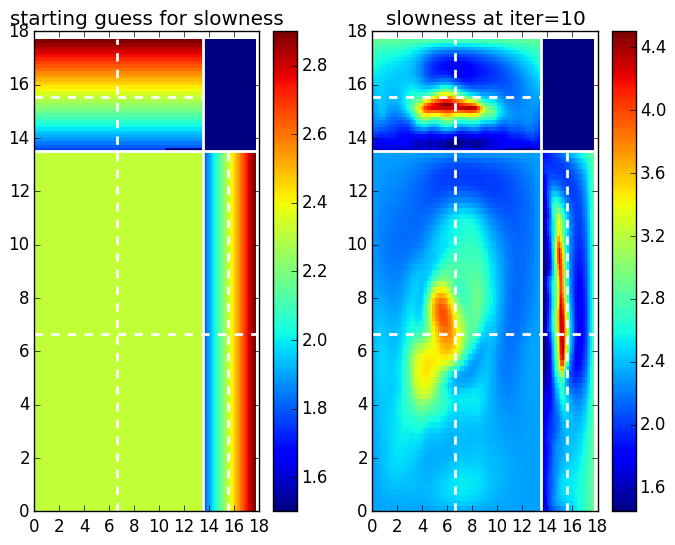

projGN iterated maxIter=10 times but reached only stepNorm of 0.19889863272442954 instead 0.01.


In [11]:
mc,Dc,flag,His = projGNCG(copy(mref[:]),pInv,pMis,dumpResults = plotIntermediates);

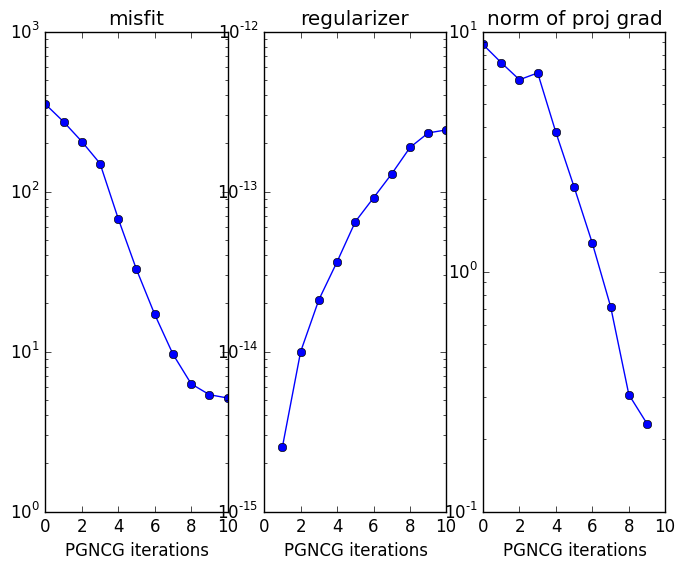

In [12]:
subplot(1,3,1)
semilogy(His.F,"-o")
xlabel("PGNCG iterations")
title("misfit")

subplot(1,3,2)
semilogy(His.Rc,"-o")
xlabel("PGNCG iterations")
title("regularizer");

subplot(1,3,3)
semilogy(His.dJ,"-o")
xlabel("PGNCG iterations")
title("norm of proj grad");

In [13]:
# fetch Eikonal data
DcEik = zeros(size(dobsEik,1),size(dobsEik,2),length(His.Dc))
for iter=1:length(His.Dc)
    for k=1:length(His.Dc[iter])-1
        Ik       = SourcesSubInd[k];
        DcEik[:,Ik,iter] = fetch(His.Dc[iter][k])
    end
end

DcDC = zeros(size(dobsDC,1),size(dobsDC,2),length(His.Dc))
for iter=1:length(His.Dc)
    DcDC[:,:,iter] = fetch(His.Dc[iter][end]);
end

His.Dc = [];
matwrite("exJointEikonalDCRes.mat",Dict("mc"=>mc,"His"=>His,"DcEik"=>DcEik,"DcDC"=>DcDC))